In [25]:
import os
#import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm


plt.close('all')

In [26]:
# %% Read a file of events and write another file with a subset of them
filename_sub = '../slider_far/events.txt'
"""
events_raw = open('slider_depth/events.txt', "r")
events_sub = open(filename_sub, "w")
# t, x, y, pol

for k in range(50000):
    line = events_raw.readline()
    #print(line)
    events_sub.write(line)

events_raw.close()
events_sub.close()
"""

# %% Read file with a subset of events
def extract_data(filename):
    infile = open(filename, 'r')
    timestamp = []
    x = []
    y = []
    pol = []
    for line in infile:
        words = line.split()
        # words[0]: t, words[1]: x
        timestamp.append(float(words[0]))
        x.append(int(words[1]))
        y.append(int(words[2]))
        pol.append(int(words[3]))
    infile.close()
    return timestamp,x,y,pol

timestamp, x, y, pol = extract_data(filename_sub)


In [27]:
def gabor_filter_even(x,y,delta,theta):
#     print(T_hat)
    x_hat=math.cos(theta)*x-math.sin(theta)*y
    y_hat=math.sin(theta)*x+math.cos(theta)*y
    Gabor_k=1/(2*math.pi*delta**2)*math.exp(-1/delta**2*math.pi*(x_hat**2+y_hat**2))*math.cos(2*math.pi*(x+y))
    return Gabor_k
def gabor_filter_even_plot(x,y,delta,theta):
#     print(T_hat)
    x_hat=math.cos(theta)*x-math.sin(theta)*y
    y_hat=math.sin(theta)*x+math.cos(theta)*y
    Gabor_k=1/(2*math.pi*delta**2)*np.exp(-1/delta**2*math.pi*(x_hat**2+y_hat**2))*np.cos(2*math.pi*(x+y))
    return Gabor_k
def gabor_filter_odd(x,y,delta,theta):
    x_hat=math.cos(theta)*x-math.sin(theta)*y
    y_hat=math.sin(theta)*x+math.cos(theta)*y
    Gabor_k=1/(2*math.pi*delta**2)*math.exp(-1/delta**2*math.pi*(x_hat**2+y_hat**2))*math.sin(2*math.pi*(x+y))
    return Gabor_k
def gabor_filter_odd_plot(x,y,delta,theta):
    x_hat=math.cos(theta)*x-math.sin(theta)*y
    y_hat=math.sin(theta)*x+math.cos(theta)*y
    Gabor_k=1/(2*math.pi*delta**2)*np.exp(-1/delta**2*math.pi*(x_hat**2+y_hat**2))*np.sin(2*math.pi*(x+y))
    return Gabor_k

In [28]:
def filter_mono(wm1,wm2,t,mium1,mium2,sigmam1,sigmam2):
    value=wm1*math.exp(-(t-mium1)**2/(2*sigmam1**2))-wm2*math.exp(-(t-mium2)**2/(2*sigmam2**2))
    return value
def filter_mono_plot(wm1,wm2,t,mium1,mium2,sigmam1,sigmam2):
    value=wm1*np.exp(-(t-mium1)**2/(2*sigmam1**2))-wm2*np.exp(-(t-mium2)**2/(2*sigmam2**2))
    return value

def filter_bi(wm1,wm2,t,mium1,mium2,sigmam1,sigmam2):
    value=wm1*math.exp(-(t-mium1)**2/(2*sigmam1**2))-wm2*math.exp(-(t-mium2)**2/(2*sigmam2**2))
    return value
def filter_bi_plot(wm1,wm2,t,mium1,mium2,sigmam1,sigmam2):
    value=wm1*np.exp(-(t-mium1)**2/(2*sigmam1**2))-wm2*np.exp(-(t-mium2)**2/(2*sigmam2**2))
    return value

In [29]:
def integation(x,y,timestamp,polarity,kernelSize,theta,delta,
               mono_wm1,mono_wm2,mono_mium1,mono_mium2,mono_sigmam1,mono_sigmam2,
               bi_wm1,bi_wm2,bi_mium1,bi_mium2,bi_sigmam1,bi_sigmam2):
    print("start")
    max_x=np.max(x)
    min_x=np.min(x)
    max_y=np.max(y)
    min_y=np.min(y)
    _x=np.arange(min_x,max_x)
    _y=np.arange(min_y,max_y)
    I={}
    for X_ in _x:
        for Y_ in _y:
            ## clc the range
            ankor_x=X_
            ankor_y=Y_
            x_min=ankor_x-(kernelSize-1)/2
            x_max=ankor_x+(kernelSize-1)/2
            y_min=ankor_y-(kernelSize-1)/2
            y_max=ankor_y+(kernelSize-1)/2
            x_=np.arange(x_min,x_max,1)
            y_=np.arange(y_min,y_max,1)
            s=0.0
            for X in x_:
                for Y in y_:
                    for k1,k2,k3,k4 in zip(x,y,timestamp,polarity):
                        if(X==k1 and Y==k2):
                            t_=k3
                            p_=k4
                            s=s+p_*(filter_bi(bi_wm1,bi_wm2,t_,bi_mium1,bi_mium2,bi_sigmam1,bi_sigmam2)*gabor_filter_even(X,Y,delta,theta)+
                                filter_mono(mono_wm1,mono_wm2,t_,mono_mium1,mono_mium2,mono_sigmam1,mono_sigmam2)*gabor_filter_odd(X,Y,delta,theta))
            print("value=",s)

            I.setdefault((ankor_x,ankor_y),[]).append(s)
    print("end")
    return I

In [30]:
mono_wm1=1.95
mono_wm2=0.23
mono_mium1=0.55
mono_mium2=0.55
mono_sigmam1=0.10
mono_sigmam2=0.16
bi_wm1=0.83
bi_wm2=0.63
bi_mium1=0.44
bi_mium2=-0.34
bi_sigmam1=0.12
bi_sigmam2=0.21

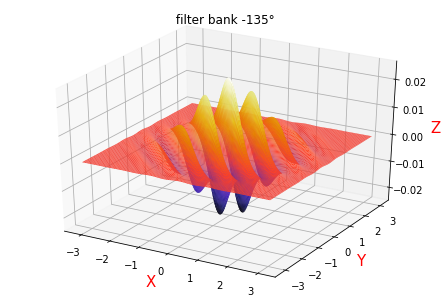

In [31]:
fig = plt.figure()
ax = Axes3D(fig)
X = np.arange(-math.pi, math.pi, math.pi/100)
Y = np.arange(-math.pi, math.pi, math.pi/100)
R=np.arange(0,math.pi,math.pi/4)
X, Y = np.meshgrid(X, Y)
Z=gabor_filter_even_plot(X,Y,2.5,R[1])
ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap=cm.CMRmap)
ax.set_title(" filter bank -135°")
ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
plt.show()

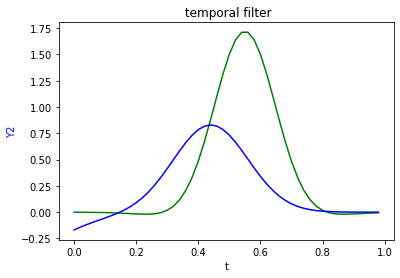

In [32]:
t = np.arange(0,1,0.02)
y1= filter_mono_plot(mono_wm1,mono_wm2,t,mono_mium1,mono_mium2,mono_sigmam1,mono_sigmam2)
y2= filter_bi_plot(bi_wm1,bi_wm2,t,bi_mium1,bi_mium2,bi_sigmam1,bi_sigmam2)

fig2,ax1 = plt.subplots()

ax1.plot(t,y1,'g-')
ax1.plot(t,y2,'b-')
ax1.set_title(" temporal filter")
ax1.set_xlabel('t')
ax1.set_ylabel('Y1',color = 'g')
ax1.set_ylabel('Y2',color = 'b')

plt.show()

In [33]:
N=4
angle =np.arange(math.pi/4,math.pi,math.pi/4)

velocity={}
for k in angle:
    I=integation(x,y,timestamp,pol,11,k,2.5,mono_wm1,mono_wm2,mono_mium1,mono_mium2,mono_sigmam1,mono_sigmam2,
               bi_wm1,bi_wm2,bi_mium1,bi_mium2,bi_sigmam1,bi_sigmam2)
    for k1,k2 in zip(x,y):
        v=0
        u=0
        for num in range(1,4):
            v=v+I[(k1,k2)]*(-math.sin(2*math.pi*(num-1)/N))
            u=u+I[(k1,k2)]*math.cos(2*math.pi*(num-1)/N)
        velocity.setdefault((k1,k2),[]).append((u,v))







start


KeyboardInterrupt: 